In [1]:
%matplotlib inline

In [1]:
# Copyright (c) 2017 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
"""
==============
Four Panel Map
==============

By reading model output data from a netCDF file, we can create a four panel plot showing:

* 300 hPa heights and winds
* 500 hPa heights and absolute vorticity
* Surface temperatures
* Precipitable water
"""

###########################################
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr

from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo

###########################################

crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

###########################################

 
# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([235., 290., 20., 55.])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax


###########################################

# Open the example netCDF data
#ds = xr.open_dataset(get_test_data('gfs_output.nc', False))

ds = xr.open_dataset('gfs.20220223t00z.1p00.f012.nc')

print(ds)

<xarray.Dataset>
Dimensions:             (latitude: 181, longitude: 360, time: 1)
Coordinates:
  * latitude            (latitude) float64 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude           (longitude) float64 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * time                (time) datetime64[ns] 2022-02-23T12:00:00
Data variables: (12/41)
    PRMSL_meansealevel  (time, latitude, longitude) float32 ...
    HGT_200mb           (time, latitude, longitude) float32 ...
    TMP_200mb           (time, latitude, longitude) float32 ...
    RH_200mb            (time, latitude, longitude) float32 ...
    UGRD_200mb          (time, latitude, longitude) float32 ...
    VGRD_200mb          (time, latitude, longitude) float32 ...
    ...                  ...
    HGT_1000mb          (time, latitude, longitude) float32 ...
    PRES_surface        (time, latitude, longitude) float32 ...
    HGT_surface         (time, latitude, longitude) float32 ...
    TMP_surface         (time, latitude, longitude) 

In [2]:
###########################################

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(ds['longitude'], ds['latitude'])

###########################################

# Pull out the data
#vort_500 = ds['vort_500'][0]
#precip_water = ds['precip_water'][0]

vort_500 = ds['UGRD_300mb'][0] * 1e-5
precip_water = ds['RH_1000mb'][0]

surface_temp = ds['TMP_surface'][0]
u_300 = ds['UGRD_300mb'][0]
v_300 = ds['VGRD_300mb'][0]
winds_300 = np.sqrt( u_300 * u_300 + v_300 * v_300 )

In [3]:
###########################################

# Do unit conversions to what we wish to plot
vort_500 = vort_500 * 1e5
surface_temp = surface_temp.metpy.convert_units('degC')
#precip_water = precip_water.metpy.convert_units('inches')
#winds_300 = winds_300.metpy.convert_units('knots')

###########################################

# Smooth the height data
#heights_300 = ndimage.gaussian_filter(ds['HGT_300mb'][0], sigma=1.5, order=0)
#heights_500 = ndimage.gaussian_filter(ds['HGT_500mb'][0], sigma=1.5, order=0)

heights_300 = ds['HGT_300mb'][0]
heights_500 = ds['HGT_500mb'][0]

###########################################

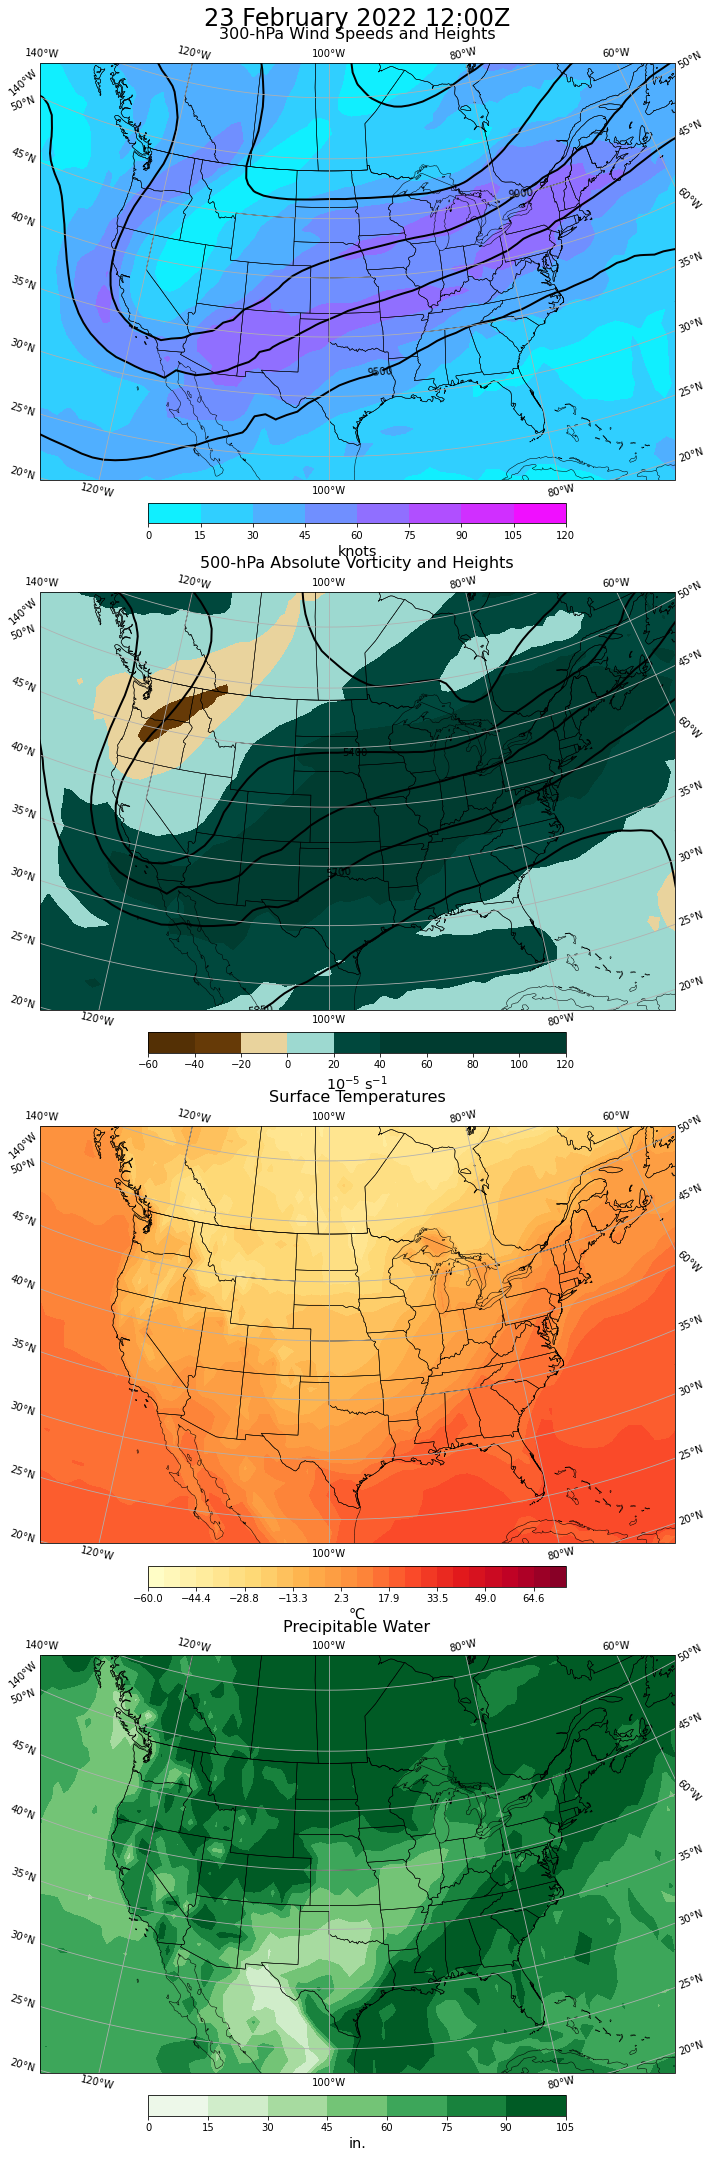

In [9]:
# Create the figure and plot background on different axes

# https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html


fig, axarr = plt.subplots(nrows=4, ncols=1, figsize=(60, 30), constrained_layout=True,
                          subplot_kw={'projection': crs})
#add_metpy_logo(fig, 140, 120, size='large')

axlist = axarr.flatten()
#for ax in axlist:
#    plot_background(ax)
    

plot_background(axarr[0])
plot_background(axarr[1])
plot_background(axarr[2])

plot_background(axarr[3])

# Upper left plot - 300-hPa winds and geopotential heights
cf1 = axlist[0].contourf(lon_2d, lat_2d, winds_300, cmap='cool', transform=ccrs.PlateCarree())
c1 = axlist[0].contour(lon_2d, lat_2d, heights_300, colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
axlist[0].clabel(c1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[0].set_title('300-hPa Wind Speeds and Heights', fontsize=16)
cb1 = fig.colorbar(cf1, ax=axlist[0], location='bottom', shrink=1.0, fraction=0.05, pad=0.05)
cb1.set_label('knots', size='x-large')


# Upper right plot - 500mb absolute vorticity and geopotential heights
cf2 = axlist[1].contourf(lon_2d, lat_2d, vort_500, cmap='BrBG', transform=ccrs.PlateCarree(),
                         zorder=0, norm=plt.Normalize(-32, 32))
c2 = axlist[1].contour(lon_2d, lat_2d, heights_500, colors='k', linewidths=2,
                       transform=ccrs.PlateCarree())
axlist[1].clabel(c2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[1].set_title('500-hPa Absolute Vorticity and Heights', fontsize=16)
cb2 = fig.colorbar(cf2, ax=axlist[1], location='bottom',  shrink=1.0, fraction=0.05, pad=0.05)
cb2.set_label(r'$10^{-5}$ s$^{-1}$', size='x-large')


# Lower left plot - surface temperatures
levels = np.linspace(-60.0, 75.0, 27)
cf3 = axlist[2].contourf(lon_2d, lat_2d, surface_temp, levels, cmap='YlOrRd',
                         transform=ccrs.PlateCarree(), zorder=0)
axlist[2].set_title('Surface Temperatures', fontsize=16)
cb3 = fig.colorbar(cf3, ax=axlist[2], location='bottom', shrink=1.0, fraction=0.05,  pad=0.05)
#cb3.set_label('\N{DEGREE FAHRENHEIT}', size='x-large')
cb3.set_label('\N{DEGREE CELSIUS}', size='x-large')

# Lower right plot - precipitable water entire atmosphere
cf4 = axlist[3].contourf(lon_2d, lat_2d, precip_water, cmap='Greens',
                         transform=ccrs.PlateCarree(), zorder=0)
axlist[3].set_title('Precipitable Water', fontsize=16)
cb4 = fig.colorbar(cf4, ax=axlist[3], location='bottom', shrink=1.0, fraction=0.05, pad=0.05)
cb4.set_label('in.', size='x-large')

# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Set figure title
fig.suptitle(ds['time'][0].dt.strftime('%d %B %Y %H:%MZ').values, fontsize=24)

# Display the plot
plt.show()